# Universidad de Buenos Aires
# Deep Learning - TP1
# Julio 2024

El TP comienza al momento de recibir este correo y la ventana de entrega estará abierta hasta el Domingo 28 de Julio inclusive. La resolución es individual. Pueden utilizar los contenidos vistos en clase y otra bibliografía. Si se toman ideas de fuentes externas deben ser correctamente citas incluyendo el correspondiente link o página de libro.

El formato de entrega debe ser un “link a un colab” (compartir a las siguientes direcciones: alfonsorafel93@gmail.com y lelectronfou@gmail.com). Tanto los resultados, como el código y las explicaciones deben quedar guardados y
visualizables en el colab. El colab debe poder ser ejecutado sin errores y las celdas no deben contener codigo que no corresponda con la ejecucion de las mismas.



## Ejercicio

Se desea construir un sistema de recomendación de películas. Para esto se cuenta con un dataset de las puntuaciones que los usuarios han asignado a las peliculas disponibles.

Link dataset: https://drive.google.com/file/d/1Og9H-8oqb3_Wo_WOakeAuRR_mwr922Ar/view?usp=sharing

Para verificar la factibilidad del proyecto con datos válidos, se decide utilizar solamente las 200 películas con más votos y sobre eso los usuarios que han puntuado al menos 100 películas.

1- Analizar el dataset para utilizar solamente las 200 películas con mayor cantidad de votos y los usuarios que hayan votado al menos 100 películas.

2- A partir del dataset del punto 1, construir una única red neuronal que utilice una capa de embeddings para el id de usuario, una capa de embeddings para el id de película y al menos dos capas lineales que sea capaz de predecir el puntaje que cada usuario colocó a cada pelicula. Usar tecnicas de normalizacion en caso de ser necesario.

3- Graficar las evoluciones de las funciones de costo en entrenamiento y validacion, como asi tambien las metricas de validacion. Explicar los resultados obtenidos.

4- Construir una funcion capaz de recibir un usuario al azar, una cantidad "p" de películas que dicho usuario haya puntuado y verificar la predicción del modelo. Comparar con los puntajes reales contra los que el usuario asignó a dicha/s película/s.

5- Contruir una funcion capaz de realizar una recomendación de película para un usuario determinado utilizando los embeddings de usuario o los embeddings de películas. Comprobar si la recomendación es correcta haciendo una predicción del puntuaje con la red neuronal.

6- Con el mejor modelo obtenido del punto 2, elegir al menos 3 hiperparametros y aplicar algun metodo de tuneo. Explicar resultados obtenidos.

## <h1><center>TP1 - Aprendizaje profundo - CEIA</center></h1>

In [1]:
# Descargamos la carpeta con archivos auxiliares
%pip install gdown
!gdown https://drive.google.com/drive/folders/1khOHrQdJJCaWiw7gCTPW7YJjI2ILbBM2?usp=sharing --folder

# Exportamos los requrimientos para reproducción local
%pip freeze > requirements.txt

Retrieving folder contents
Retrieving folder 1BYbp5VwmGpGK0jv-serRtShl_QF79hMQ datasets
Processing file 1ZVshxm8UblIYqPBYxvZkOte5xuErsGAB ratings.csv
Retrieving folder 1Fgr-XEyleLdrZIMlfNxUI-e2K1ywMVe8 images
Processing file 1BzJqme6Xg8HlY1zLu5dCotE_8yn0E5qg portada.jpeg
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1ZVshxm8UblIYqPBYxvZkOte5xuErsGAB
To: /content/resources/datasets/ratings.csv
100% 2.48M/2.48M [00:00<00:00, 100MB/s]
Downloading...
From: https://drive.google.com/uc?id=1BzJqme6Xg8HlY1zLu5dCotE_8yn0E5qg
To: /content/resources/images/portada.jpeg
100% 362k/362k [00:00<00:00, 93.5MB/s]
Download completed


<center>

<img src="https://drive.google.com/uc?id=1BzJqme6Xg8HlY1zLu5dCotE_8yn0E5qg" width="600" alt="Figura 1: An artificial brain with serveral movies photos inside it - Generada con Microsoft Image Creator">

<small><em>Figura 1: An artificial brain with serveral movies photos inside it - Generada con Microsoft Image Creator</em></small>

</center>

<center>
<em>Datos del proyecto:</em>

| Subtitulo   | TP1 - Aprendizaje profundo - FIUBA                                                                                                     |
| ----------- | ---------------------------------------------------------------------------------------------------------------------------------------------- |
| **Descrpción**  | Construcción de un sistema de recomendación de películas                          |
| **Integrantes** | • Bruno Masoller (brunomaso1@gmail.com)|

</center>

In [2]:
# Importaciones
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
import matplotlib.pyplot as plt
import os
import tempfile

In [3]:
# Parámetros
BATCH_SIZE = 10 # Tamaño del batch
N_EPOCHS = 10 # Número de épocas
VERBOSE = True # Muestra época a época la evolución
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f'Dispositivo actual: {DEVICE}')

Dispositivo actual: cuda


### Parte 1

> Analizar el dataset para utilizar solamente las 200 películas con mayor cantidad de votos y los usuarios que hayan votado al menos 100 películas.

*Primeramente, analizamos características del conjunto:*

In [4]:
# Cargamos el dataset.
# https://grouplens.org/datasets/movielens/latest/
df = pd.read_csv('/content/resources/datasets/ratings.csv')
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
# Mostramos datos estadísticos del conjunto.
df.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [6]:
# Mostramos los tipos de datos.
df.dtypes

userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object

In [7]:
# Verficamos que no tenga duplicados ni valores nulos.
print(f'Datos duplicados: {df.duplicated().sum()}')
print(f'Valores nulos:\n{df.isnull().sum()}')

Datos duplicados: 0
Valores nulos:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


*Obtenemos los usuarios que han votado en al menos 100 peliculas y de estas nos quedamos con las 200 películas más votadas:*

In [8]:
# Usuarios que votaron en al menos 100 peliculas.
df = df.groupby('userId').filter(lambda x: len(x) >= 100)

# Las 200 peliculas con la mayor cantidad de votos.
df = df.sort_values(by='rating', ascending=False).head(200)

In [9]:
# Contamos la cantidad.
df.shape

(200, 4)

In [10]:
# Eliminamos la columna timestamp que no nos aporta para este problema.
df = df.drop('timestamp', axis=1)

### Parte 2

> A partir del dataset del punto 1, construir una única red neuronal que utilice una capa de embeddings para el id de usuario, una capa de embeddings para el id de película y al menos dos capas lineales que sea capaz de predecir el puntaje que cada usuario colocó a cada pelicula. Usar tecnicas de normalizacion en caso de ser necesario.

*Verificamos la cardinalidad de las características `userID` y `movieId`:*

In [11]:
print('Cardinalidad de userId: ', df['userId'].nunique())
print('Cardinalidad de movieId: ', df['movieId'].nunique())

Cardinalidad de userId:  8
Cardinalidad de movieId:  193


*Definimos la clase DataSet, necesaria por pytorch:*

In [12]:
# Construimos la clase Dataset
class MovieRatingDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

*Definimos la arquitectura de la Red Neuronal:*

In [13]:
# Definimos la Redneuronal
class RecommenderNet(nn.Module):
  def __init__(self, num_users, num_movies, embedding_size=50):
    super(RecommenderNet, self).__init__()
    # Definimos los embedings.
    self.user_embedding = nn.Embedding(num_users, embedding_size)
    self.movie_embedding = nn.Embedding(num_movies, embedding_size)

    # Definimos las capas
    self.input_layer = nn.Linear(embedding_size * 2, 128)
    self.hidden_layer = nn.Linear(128, 32)
    self.output_layer = nn.Linear(32, 1)
    self.dropout = nn.Dropout(0.2)
    self.sigmoid = nn.Sigmoid()
    self.relu = nn.ReLU()

  def forward(self, X):
    # Obtenemos el id
    encoded_user_id = X[:, 0].long()
    encoded_movie_id = X[:, 1].long()

    # Obtenemos los embedings
    user_embedded = self.user_embedding(encoded_user_id)
    movie_embedded = self.movie_embedding(encoded_movie_id)

    # Concatenamos los embedings
    x = torch.cat([user_embedded, movie_embedded], dim=1)

    # Aplicamos las capas
    x = self.relu(self.input_layer(x))
    x = self.dropout(x)
    x = self.relu(self.hidden_layer(x))
    x = self.dropout(x)
    x = self.output_layer(x)
    x = self.sigmoid(x) * 4 + 1 # Transformar salida a rango [1, 5]
    return x.flatten() # Aplanamos el vector de salida (1D)

*Encodeamos las características `userId` y `movieId`:*

In [14]:
user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()

user_encoder.fit(df['userId'])
movie_encoder.fit(df['movieId'])

LabelEncoder()

*Dividimos los datos en entrenamiento y validación:*

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df[['userId', 'movieId']], df['rating'], test_size=0.2, random_state=42)

*Aplicamos las transformaciones de los datos a __train__ y __validación__ por separado:*

In [16]:
X_train['userId'] = user_encoder.transform(X_train['userId'])
X_train['movieId'] = movie_encoder.transform(X_train['movieId'])

X_test['userId'] = user_encoder.transform(X_test['userId'])
X_test['movieId'] = movie_encoder.transform(X_test['movieId'])

*Creamos los `Dataset` y `DataLoader` de pytorch:*

In [17]:
train_dataset = MovieRatingDataset(X_train.values, y_train.values)
test_dataset = MovieRatingDataset(X_test.values, y_test.values)

# Para el train_loader configuramos suffle=True para que mezcle los datos.
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

*Instanciamos la red (como parámetro, le pasamos la cantidad de clases de cada característica para los embedings):*

In [18]:
num_users = len(user_encoder.classes_)
num_movies = len(movie_encoder.classes_)

# Instanciamos la red en el dispositivo seteado
model = RecommenderNet(num_users, num_movies).to(DEVICE)

*Definimos la función de costo. Para esta caso, utilizamos el MSE (Mean Square Error) dado que la salida es una regresión:*

In [19]:
criterion = nn.MSELoss()

*Definimos el optimizador. En este caso, Adam, con los parámetros por defecto:*

In [20]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

*Una vez definidos todos los puntos necesarios para problemas de aprendizaje profundo (arquitectura, función de costo y optimizador), entrenamos la red:*

In [21]:
# Listas para guardar los valores de pérdida
train_losses = []
test_losses = []
train_mapes = []
test_mapes = []

In [22]:
print('Training...\n')
for epoch in range(N_EPOCHS):
    train_loss = 0.0
    test_loss = 0.0
    train_mape = 0.0
    test_mape = 0.0

    train_y = []
    train_y_hat = []
    test_y = []
    test_y_hat = []

    # Entrenamiento
    model.train()  # Poner el modelo en modo de entrenamiento
    for i, (X_batch, y_batch) in enumerate(train_loader):
        X_batch = X_batch.to(DEVICE).float()
        y_batch = y_batch.to(DEVICE).float()

        optimizer.zero_grad()   # Ponemos los parámetros del gradiente a 0

        y_batch_hat = model(X_batch) # Pasada forward
        loss = criterion(y_batch_hat, y_batch) # Computar la función de costo
        loss.backward()         # Propagar el error
        optimizer.step()        # Actualizar los parámetros.

        train_y += list(y_batch.detach().cpu().numpy())
        train_y_hat += list(y_batch_hat.detach().cpu().numpy())

        train_loss += loss.item() # Acumulamos el error.

    # Evaluación
    model.eval()  # Poner el modelo en modo de evaluación
    with torch.no_grad():  # No necesitamos calcular gradientes durante la evaluación
        for (X_batch, y_batch) in test_loader:
            X_batch = X_batch.to(DEVICE).float()
            y_batch = y_batch.to(DEVICE).float()

            y_batch_hat = model(X_batch)
            loss = criterion(y_batch_hat, y_batch)

            test_y += list(y_batch.detach().cpu().numpy())
            test_y_hat += list(y_batch_hat.detach().cpu().numpy())
            test_loss += loss.item()

    train_loss /= len(train_loader)
    train_mape = metrics.mean_absolute_percentage_error(train_y, train_y_hat)
    test_loss /= len(test_loader)
    test_mape = metrics.mean_absolute_percentage_error(test_y, test_y_hat)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_mapes.append(train_mape)
    test_mapes.append(test_mape)

    if VERBOSE:
        print(f" Epoch {epoch} | " \
        f"Train/Valid loss: {train_loss:.3f} / {test_loss:.3f} | " \
        f"Train/Valid MAPE: {train_mape:.3f} / {test_mape:.3f}")

print('\nFinished Training')

Training...

 Epoch 0 | Train/Valid loss: 1.948 / 0.714 | Train/Valid MAPE: 0.270 / 0.163
 Epoch 1 | Train/Valid loss: 0.282 / 0.099 | Train/Valid MAPE: 0.088 / 0.050
 Epoch 2 | Train/Valid loss: 0.051 / 0.026 | Train/Valid MAPE: 0.030 / 0.023
 Epoch 3 | Train/Valid loss: 0.016 / 0.011 | Train/Valid MAPE: 0.017 / 0.015
 Epoch 4 | Train/Valid loss: 0.012 / 0.007 | Train/Valid MAPE: 0.013 / 0.012
 Epoch 5 | Train/Valid loss: 0.005 / 0.005 | Train/Valid MAPE: 0.008 / 0.010
 Epoch 6 | Train/Valid loss: 0.003 / 0.004 | Train/Valid MAPE: 0.008 / 0.009
 Epoch 7 | Train/Valid loss: 0.003 / 0.003 | Train/Valid MAPE: 0.007 / 0.008
 Epoch 8 | Train/Valid loss: 0.002 / 0.003 | Train/Valid MAPE: 0.007 / 0.007
 Epoch 9 | Train/Valid loss: 0.002 / 0.002 | Train/Valid MAPE: 0.006 / 0.007

Finished Training


### Parte 3

> Graficar las evoluciones de las funciones de costo en entrenamiento y validacion, como asi tambien las metricas de validacion. Explicar los resultados obtenidos.

*Calculamos algunas métricas de evaluación:*

In [23]:
def imprimir_metricas_validacion(y_test, test_y_hat):
  mse = metrics.mean_squared_error(y_test, test_y_hat)
  rmse = np.sqrt(mse)
  mae = metrics.mean_absolute_error(y_test, test_y_hat)
  r2 = metrics.r2_score(y_test, test_y_hat)
  evs = metrics.explained_variance_score(y_test, test_y_hat)
  mape = metrics.mean_absolute_percentage_error(y_test, test_y_hat)

  print(f'MSE: {mse}')
  print(f'RMSE: {rmse}')
  print(f'MAE: {mae}')
  # print(f'R²: {r2}') # No tiene sentido, la varianza en este caso es 0 (son todos constantes los y)
  # print(f'Explained Variance Score: {evs}') # No tiene sentido, la varianza en este caso es 0.
  print(f'MAPE: {mape}')

In [24]:
imprimir_metricas_validacion(y_test, test_y_hat)

MSE: 0.002227601803201651
RMSE: 0.0471974766613815
MAE: 0.03324716091156006
MAPE: 0.006649432182312012


*Graficamos la evolución del proceso:*

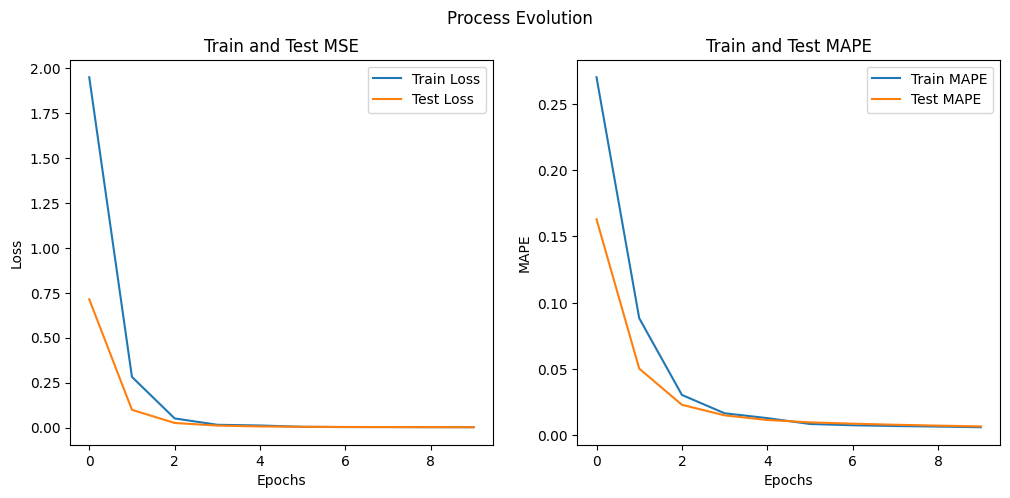

In [25]:
# Graficar las pérdidas (losses)
plt.figure(figsize=(12, 5))
plt.suptitle('Process Evolution')

plt.subplot(1, 2, 1)
plt.plot(range(N_EPOCHS), train_losses, label='Train Loss')
plt.plot(range(N_EPOCHS), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test MSE')
plt.legend()

# Graficar las MAPE
plt.subplot(1, 2, 2)
plt.plot(range(N_EPOCHS), train_mapes, label='Train MAPE')
plt.plot(range(N_EPOCHS), test_mapes, label='Test MAPE')
plt.xlabel('Epochs')
plt.ylabel('MAPE')
plt.title('Train and Test MAPE')
plt.legend()

plt.show()


*En la evolución del proceso podemos ver que se reducen los erroes tanto en el conjunto de entrenamiento como en el de testing, lo que significa que la red no está pasando por una etapa de "overfiting" y está generalizando de forma correcta.*

*En este caso, luego de la 4 época ya no se logra reducir más ambos errores. No tiene sentido seguir entrenado, pero se deja en evidencia este caso, para ver si luego, en la optimización de hiperparámetros surge esta razón. También destacar que la métrica de MAPE llega a su mínimo en aproximadamente 0.8%.*

*Para este caso $R^2$ no tiene sentido, dado que no se tiene una varianza explicada por el modelo, ya que todas las predicciones son constantes.*

### Parte 4

> Construir una funcion capaz de recibir un usuario al azar, una cantidad "p" de películas que dicho usuario haya puntuado y verificar la predicción del modelo. Comparar con los puntajes reales contra los que el usuario asignó a dicha/s película/s.

*Cantidad de usuarios y películas en el dataset:*

In [26]:
# Cantidad de usuarios/peliculas
df.groupby('userId').count()

,movieId,rating
userId,,
89,58,58
91,20,20
184,1,1
294,10,10
298,1,1
414,41,41
571,11,11
572,58,58


*Función para predecir el score de un usuario (user_id) dado una cantidad de películas:*

In [27]:
def verify_movie_score(model: nn.Module, user_encoder: LabelEncoder, movie_encoder: LabelEncoder, df: pd.DataFrame, user_id: int, p: int = 5) -> pd.DataFrame:
    """
    Predice las puntuaciones de películas para un usuario específico y compara las predicciones con las puntuaciones reales.

    Args:
        model (nn.Module): El modelo de recomendación entrenado.
        user_encoder (LabelEncoder): Codificador para transformar IDs de usuarios.
        movie_encoder (LabelEncoder): Codificador para transformar IDs de películas.
        df (pd.DataFrame): DataFrame que contiene las puntuaciones de las películas.
        user_id (int): ID del usuario para el cual se realizarán las predicciones.
        p (int, opcional): Número de películas a evaluar para el usuario. Por defecto es 5.

    Returns:
        pd.DataFrame: DataFrame que contiene las puntuaciones reales, las puntuaciones predichas y las categorías de las puntuaciones predichas.
    """

    # Filtrar las primeras p filas del usuario especificado
    user_data = df.loc[df['userId'] == user_id].head(p).copy()
    if user_data.empty:
        print(f'No hay datos para el usuario {user_id}')
        return None

    # Obtener las categorías de puntuación únicas y ordenarlas en orden descendente
    df_ratings_categories = sorted(df['rating'].unique(), reverse=True)

    # Codificar los IDs del usuario y las películas y convertirlos en tensores
    user_data['userId'] = user_encoder.transform(user_data['userId'])
    user_data['movieId'] = movie_encoder.transform(user_data['movieId'])
    X_batch = torch.tensor(user_data[['userId', 'movieId']].values).to(DEVICE)
    y_batch = torch.tensor(user_data['rating'].to_numpy()).float().reshape(-1, 1).to(DEVICE)

    # Mover el modelo al dispositivo especificado (CPU o GPU)
    model.to(DEVICE)

    # Poner el modelo en modo de evaluación y deshabilitar el cálculo de gradientes
    model.eval()
    with torch.no_grad():
        # Realizar predicciones con el modelo
        y_batch_hat = model(X_batch)

    # Convertir las predicciones a un arreglo numpy
    y_batch_hat = y_batch_hat.detach().cpu().numpy().flatten()

    # Aplicamos la transformación inversa del encoder
    user_data['userId'] = user_encoder.inverse_transform(user_data['userId'])
    user_data['movieId'] = movie_encoder.inverse_transform(user_data['movieId'])

    # Asignamos la categoría de puntuación predicha redondeando cada predicción al valor más cercano en df_ratings_categories
    # Encuentra el valor más cercano a 'pred' en df_ratings_categories
    # Itera sobre cada predicción en y_batch_hat
    user_data['predicted_rating_category'] = [min(df_ratings_categories, key=lambda x: abs(x - pred)) for pred in y_batch_hat]

    # Añadir las predicciones al DataFrame
    user_data['predicted_rating'] = y_batch_hat

    # Calcular el error cuadrático medio (MSE) entre las puntuaciones reales y las predicciones
    user_data['MSE'] = metrics.mean_squared_error(y_batch.detach().cpu().numpy(), y_batch_hat)

    return user_data

*Ejemplos de uso:*

In [28]:
# NOTA: Si el dispositivo es GPU, cambia el orden del cojunto, por lo que cambian
# los usuarios.
if DEVICE == 'cuda':
    test_userId, test_p = 89, 5
else:
    test_userId, test_p = 1, 5

verify_movie_score(model, user_encoder, movie_encoder, df, test_userId, test_p)

,userId,movieId,rating,predicted_rating_category,predicted_rating,MSE
14022,89,149508,5.0,5.0,4.982288,0.000166
14023,89,149566,5.0,5.0,4.990234,0.000166
14024,89,150554,5.0,5.0,4.993136,0.000166
14029,89,156025,5.0,5.0,4.987031,0.000166
14031,89,157296,5.0,5.0,4.985739,0.000166


### Parte 5

> Contruir una funcion capaz de realizar una recomendación de película para un usuario determinado utilizando los embeddings de usuario o los embeddings de películas. Comprobar si la recomendación es correcta haciendo una predicción del puntuaje con la red neuronal.

<em>El algoritmo ideado en este caso es el siguiente:
1. Recibir un id de usuario.
2. Obtener la película mejor puntuada para dicho usuario.
3. Obtener el embeding de dicha película.
4. Devolver las n películas más similares (utilizando la métrica de similitud de coseno) a la pelicula anteriormente encontrada.
</em>





In [29]:
def obtener_mejor_pelicula_puntuada(user_id: int, df: pd.DataFrame) -> pd.Series:
  # Obtener las puntuaciones que dicho usuario realizó.
  user_ratings = df[df['userId'] == user_id]

  # Devolver la película mejor puntuada.
  return user_ratings.loc[user_ratings['rating'].idxmax()]['movieId']

In [30]:
def recomendar_peliculas(model: nn.Module, movie_encoder: LabelEncoder, df: pd.DataFrame, user_id: int, n: int = 5) -> pd.DataFrame:
  # Obtener la mejor pelicula puntuada por el usuario.
  best_movie_id = obtener_mejor_pelicula_puntuada(user_id, df)

  # Encodear el id de película
  best_movie_id_encoded = movie_encoder.transform([best_movie_id])

  # Obtener el embedding de la mejor pelicula
  best_movie_embedding = model.movie_embedding(torch.tensor(best_movie_id_encoded, device=DEVICE)).detach().cpu().numpy()

  # Obtener todos los embedings de las peliculas
  model.eval()
  movie_embeddings = model.movie_embedding.weight.detach().cpu().numpy()

  # Calcular la similitud de coseno entre la mejor pelicula y todas las demás
  similar_embedings = F.cosine_similarity(torch.tensor(best_movie_embedding), torch.tensor(movie_embeddings), dim=1)

  # Obtener los índices de las peliculas con mayor similitud
  top_movies_id_encoded = similar_embedings.argsort(descending=True).numpy()

  # Eliminamos la pelicula mejor puntuada (la que utilizamos para calcular los embedings)
  top_movies_id_encoded = top_movies_id_encoded[top_movies_id_encoded != best_movie_id_encoded]

  # Devolver las n peliculas más similares (antes des encondear los ids de las peliculas)
  return df[df['movieId'].isin(movie_encoder.inverse_transform(top_movies_id_encoded[:n]))]

In [31]:
df_to_predict = recomendar_peliculas(model, movie_encoder, df, test_userId, test_p)
df_to_predict

,userId,movieId,rating
88529,572,260,5.0
88419,571,968,5.0
88620,572,1945,5.0
88596,572,1292,5.0
13946,89,126088,5.0


*Generamos una función, que dado un Dataframe, realice la predicción y agregue dicha infomación como columna. La predicción se realiza con el valor de la regresión directamente para mayor pecisión.*

In [32]:
def predict_movie_score(model: nn.Module, user_encoder: LabelEncoder, movie_encoder: LabelEncoder, df_to_predict: pd.DataFrame) -> pd.DataFrame:
    df = df_to_predict.copy()

    # Codificar los IDs del usuario y las películas y convertirlos en tensores
    df['userId'] = user_encoder.transform(df['userId'])
    df['movieId'] = movie_encoder.transform(df['movieId'])
    X_batch = torch.tensor(df[['userId', 'movieId']].values).to(DEVICE)

    # Mover el modelo al dispositivo especificado (CPU o GPU)
    model.to(DEVICE)

    # Poner el modelo en modo de evaluación y deshabilitar el cálculo de gradientes
    model.eval()
    with torch.no_grad():
        # Realizar predicciones con el modelo
        y_batch_hat = model(X_batch)

    # Convertir las predicciones a un arreglo numpy
    y_batch_hat = y_batch_hat.detach().cpu().numpy().flatten()

    # Aplicamos la transformación inversa del encoder
    df['userId'] = user_encoder.inverse_transform(df['userId'])
    df['movieId'] = movie_encoder.inverse_transform(df['movieId'])

    # Añadir las predicciones al DataFrame
    df['predicted_rating'] = y_batch_hat

    return df

*Primeramente, asignamos el usuario a predecir a todo el conjunto anterior para comprobar las prediciones:*

In [33]:
df_to_predict.loc[:, 'userId'] = test_userId
df_to_predict

,userId,movieId,rating
88529,89,260,5.0
88419,89,968,5.0
88620,89,1945,5.0
88596,89,1292,5.0
13946,89,126088,5.0


*Finalmente, realizamos la predicción en batch:*

In [34]:
df_predicted = predict_movie_score(model, user_encoder, movie_encoder, df_to_predict)
df_predicted

,userId,movieId,rating,predicted_rating
88529,89,260,5.0,4.987004
88419,89,968,5.0,4.986509
88620,89,1945,5.0,4.992150
88596,89,1292,5.0,4.988863
13946,89,126088,5.0,4.978132


*Una mejora posible, sería otener n peliculas mejor puntuadas por el usuario (también se podría incorporar información de categorías si está dicha información disponible), y obtener peliculas similares de esas n películas (se puede tomar una aleatoria dentro de esas n por ejemplo, o hacer todas con todas)*

### Parte 6

> Con el mejor modelo obtenido del punto 2, elegir al menos 3 hiperparametros y aplicar algun metodo de tuneo. Explicar resultados obtenidos.

#### Optimización utilizando Scikit-Learn

<small> https://skorch.readthedocs.io/en/stable/ </small>

*En esta sección, se utiliza Scikit-Learn para realizar la optimización de hiperparámetros.*

*Se utiliza un wrapper sobre pytorch (skorch) que permite utilizar la misma semántica de scikit-learn, por ejemplo, los métodos de los transformers (fit, transform) o de los modelos (predict).*

In [35]:
# Instalamos skorch (un wrapper sobre pytorch que permite utilizar la semántica)
# de sklearn
%pip install skorch

In [36]:
# Importamos skorch
from skorch import NeuralNetRegressor
from sklearn.model_selection import GridSearchCV, ShuffleSplit

In [37]:
# Creamos el wrapper del modelo
model = NeuralNetRegressor(module=RecommenderNet,
                           # Parametros __init__ de RecomenderNet
                           module__num_users=num_users,
                           module__num_movies=num_movies,
                           # Parametros del entrenamiento
                           max_epochs=10,
                           lr=0.001,
                           batch_size=10,
                           criterion=nn.MSELoss,
                           optimizer=optim.Adam,
                           device=DEVICE,
                           verbose=True)

In [38]:
# Configuramos los parámetros de búsqueda
param_grid = {
    'batch_size': [1, 5, 10],
    'max_epochs': [2, 4, 6],
    'lr': [0.001, 0.01, 0.1]
}

In [39]:
# Configuramos la grilla y realizamos la búsqueda
grid = GridSearchCV(model, param_grid, n_jobs=-1, cv=ShuffleSplit(n_splits=1, test_size=0.3), scoring='neg_mean_squared_error')
grid_result = grid.fit(X_train.values.astype(np.float32), y_train.values.astype(np.float32))

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0296        0.0000  0.5241
      2        0.0000        0.0000  0.6387


In [40]:
# Imprime los mejores parámetros
print("Mejores hiperparámetros encontrados: ", grid_result.best_params_)
print("Mejor score: ", grid_result.best_score_)

Mejores hiperparámetros encontrados:  {'batch_size': 1, 'lr': 0.1, 'max_epochs': 2}
Mejor score:  0.0


*Luego de encontrado los mejores parámetros, entrenamos el modelos con dichos parámetros y obtenemos el error en el conjunto de test:*

In [41]:
# Entrenamos el modelo con los mejores parámetros
model.set_params(**grid_result.best_params_)
model.fit(X_train.values.astype(np.float32), y_train.values.astype(np.float32))

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0287        0.0000  0.6124
      2        0.0000        0.0000  0.3225


<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=RecommenderNet(
    (user_embedding): Embedding(8, 50)
    (movie_embedding): Embedding(193, 50)
    (input_layer): Linear(in_features=100, out_features=128, bias=True)
    (hidden_layer): Linear(in_features=128, out_features=32, bias=True)
    (output_layer): Linear(in_features=32, out_features=1, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (sigmoid): Sigmoid()
    (relu): ReLU()
  ),
)

In [42]:
# Realizamos la predicción con los valores de test
test_y_hat = model.predict(X_test.values.astype(np.float32))

In [43]:
imprimir_metricas_validacion(y_test, test_y_hat)

MSE: 0.0
RMSE: 0.0
MAE: 0.0
MAPE: 0.0


*Como conclusión, podemos observar que luego de optimizado los parámetros, tenemos literalmente 0 de error. Esto al principio suena medio raro, pero dados dichos datos no es de extrañar. Habría que probar en todo el cojunto para validar dicho caso.*

#### Optimización utilizando Optuna

<small> https://optuna.org/ </small>

*En esta sección, se utiliza Optuna para realizar la optimización de hiperparámetros.*

*Optuna nos permite buscar en todo el espectro de hiperparámetros de forma fácil, y a diferencia de Scikit-Learn, el cilco queda más parecido a la forma en que se aplicó al principio.*

*Optuna define una función objetivo a maximizar (o minimizar) en donde debemos encapsular la lógica de la red neuronal para optimizar sus parámetros. Originalmente, si queremos optimizar parámetros internos de la red (por ejemplo, el número de capas o neuronas) debemos modificar dicha red para hacerla paramétrica. En este caso, simplemente se basa en la optimización de hiperparámetros "exteriores" como el batch_size o la cantidad de épocas (el learning rate también se puede confirgurar de forma "exterior" por lo que se incluye en este caso).*

In [44]:
# Instalamos optuna
%pip install optuna

In [45]:
# Importamos las dependencias
import optuna
from optuna.trial import TrialState

In [46]:
# Creamos la función objetivo
def objective(trial):
    # Creamos el modelo
    model = RecommenderNet(num_users, num_movies).to(DEVICE)

    # Configuramos los hiperparámetros variables
    # Aplicamos transformaciones para obtener los mísmos parámetros que probar
    # que en todos los frameworks.
    BATCH_SIZE = trial.suggest_int('batch_size', 0, 10, step=5)
    BATCH_SIZE = 1 if BATCH_SIZE == 0 else BATCH_SIZE # [1, 5, 10]
    N_EPOCHS = trial.suggest_int('n_epochs', 2, 6, step=2)
    lr = 10 ** trial.suggest_int('lr', -3, -1, step=1) # [0.001, 0.01, 0.1]

    # Configuramos hiperparámetros fijos
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    for epoch in range(N_EPOCHS):
      model.train()
      for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        X_batch = X_batch.to(DEVICE).float()
        y_batch = y_batch.to(DEVICE).float()

        optimizer.zero_grad()
        y_batch_hat = model(X_batch)
        loss = criterion(y_batch_hat, y_batch)
        loss.backward()
        optimizer.step()

      model.eval()
      test_loss = 0.0
      with torch.no_grad():
          for (X_batch, y_batch) in test_loader:
              X_batch = X_batch.to(DEVICE).float()
              y_batch = y_batch.to(DEVICE).float()

              y_batch_hat = model(X_batch)

              loss = criterion(y_batch_hat, y_batch)
              test_loss += loss.item()

      # Utilizamos la pérdida MSE
      test_loss /= len(test_loader)

      trial.report(test_loss, epoch)

      if trial.should_prune():
          raise optuna.exceptions.TrialPruned()

    return test_loss

*Ejecutamos la optimización:*

In [47]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_jobs=-1, n_trials=30, timeout=600)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Estadísticas del estudio: ")
print("Número de ensayos: ", len(study.trials))
print("Número de ramas podadas: ", len(pruned_trials))
print("Número de ensayos terminados: ", len(complete_trials))

Estadísticas del estudio: 
Número de ensayos:  30
Número de ramas podadas:  9
Número de ensayos terminados:  21


In [48]:
# Observamos algunos estudios
study.trials_dataframe().sort_values(by=['value'], ascending=True).head(5)

,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_lr,params_n_epochs,state
0,0,0.0,2024-07-27 18:24:08.909937,2024-07-27 18:24:09.322124,0 days 00:00:00.412187,10,-2,2,COMPLETE
27,27,0.0,2024-07-27 18:24:20.373281,2024-07-27 18:24:20.653839,0 days 00:00:00.280558,10,-1,2,COMPLETE
26,26,0.0,2024-07-27 18:24:19.798737,2024-07-27 18:24:20.362969,0 days 00:00:00.564232,10,-1,4,COMPLETE
24,24,0.0,2024-07-27 18:24:19.071251,2024-07-27 18:24:19.576540,0 days 00:00:00.505289,10,-1,4,COMPLETE
23,23,0.0,2024-07-27 18:24:18.342462,2024-07-27 18:24:19.056186,0 days 00:00:00.713724,10,-1,6,COMPLETE


*Nota: Si bien aparece "-1" como learning rate, lo que se probó no es exactamente eso, sino que se aplicó una transformación a dicho learning rate.*

In [49]:
# Imprime los mejores parámetros
trial = study.best_trial

# Aplicamos las mismas transformaciones que al principio
trial.params['batch_size'] = 1 if trial.params['batch_size'] == 0 else trial.params['batch_size']
trial.params['lr'] = 10 ** trial.params['lr']

print("Mejores hiperparámetros encontrados: ", trial.params)
print("Mejor score: ", trial.value)

Mejores hiperparámetros encontrados:  {'batch_size': 10, 'n_epochs': 2, 'lr': 0.01}
Mejor score:  0.0


In [50]:
# Entrenamos la red con los mejores parámetros.
model = RecommenderNet(num_users, num_movies).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=trial.params['lr'])
criterion = nn.MSELoss()

train_loader = DataLoader(train_dataset, batch_size=trial.params['batch_size'], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=trial.params['batch_size'], shuffle=False)

print('Training...\n')
for epoch in range(trial.params['n_epochs']):
    # Entrenamiento
    train_loss = 0.0
    model.train()  # Poner el modelo en modo de entrenamiento
    for i, (X_batch, y_batch) in enumerate(train_loader):
        X_batch = X_batch.to(DEVICE).float()
        y_batch = y_batch.to(DEVICE).float()

        optimizer.zero_grad()   # Ponemos los parámetros del gradiente a 0

        y_batch_hat = model(X_batch) # Pasada forward
        loss = criterion(y_batch_hat, y_batch) # Computar la función de costo
        loss.backward()         # Propagar el error
        optimizer.step()        # Actualizar los parámetros.

        train_loss += loss.item() # Acumulamos el error.

    print(f" Epoch {epoch} | " \
    f"Train loss: {train_loss:.3f}")

print('\nFinished Training')

Training...

 Epoch 0 | Train loss: 7.226
 Epoch 1 | Train loss: 0.000

Finished Training


In [51]:
# Evaluación
test_y_hat = []
test_y = []
model.eval()  # Poner el modelo en modo de evaluación
with torch.no_grad():  # No necesitamos calcular gradientes durante la evaluación
    for (X_batch, y_batch) in test_loader:
        X_batch = X_batch.to(DEVICE).float()
        y_batch = y_batch.to(DEVICE).float()

        y_batch_hat = model(X_batch)

        test_y += list(y_batch.detach().cpu().numpy())
        test_y_hat += list(y_batch_hat.detach().cpu().numpy())

imprimir_metricas_validacion(test_y, test_y_hat)

MSE: 3.694822225952521e-13
RMSE: 6.078504952711228e-07
MAE: 1.0728835775353218e-07
MAPE: 2.1457672971791908e-08


#### Optimizacion utilizano Ray Tune

<small> https://docs.ray.io/en/latest/tune/index.html </small>

*Ray es un framework, que más allá de permitir la optimización, permite escalar aplicaciones de machine learning. Proporciona la capa necesaria para el procesamiento en paralelo. La librería que se utiliza exactamente para el tuneo de hiperparámetros se llama "tune", dentro de todo el framework de Ray.*

In [52]:
# Las librerías exactas para ML son:
%pip install -U "ray[data,train,tune,serve]"

In [53]:
# Importams las librerias
from ray import train, tune
from ray.tune.schedulers import ASHAScheduler
from ray.train import Checkpoint

In [54]:
# Definimos casi la misma función objetivo de en optuna
def objective(config):
    # Creamos el modelo
    model = RecommenderNet(num_users, num_movies).to(DEVICE)

    # A diferencia de optuna, los parámetros se "defien" afuera de la función
    optimizer = optim.Adam(model.parameters(), lr=config["lr"])
    criterion = nn.MSELoss()

    train_loader = DataLoader(
        train_dataset, batch_size=config["batch_size"], shuffle=True)
    test_loader = DataLoader(
        test_dataset, batch_size=config["batch_size"], shuffle=False)

    for epoch in range(config["n_epocs"]):
        model.train()
        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            X_batch = X_batch.to(DEVICE).float()
            y_batch = y_batch.to(DEVICE).float()

            optimizer.zero_grad()
            y_batch_hat = model(X_batch)
            loss = criterion(y_batch_hat, y_batch)
            loss.backward()
            optimizer.step()

        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for (X_batch, y_batch) in test_loader:
                X_batch = X_batch.to(DEVICE).float()
                y_batch = y_batch.to(DEVICE).float()

                y_batch_hat = model(X_batch)

                loss = criterion(y_batch_hat, y_batch)
                test_loss += loss.item()

        # Utilizamos la pérdida MSE
        test_loss /= len(test_loader)

        # Send the current training result back to Tune
        train.report({"neg_mean_squared_error": test_loss})

In [55]:
# Defimimos el espacio de busqueda
search_space = {
    "lr": tune.grid_search([0.001, 0.01, 0.1]),
    "batch_size": tune.grid_search([1, 5, 10]),
    "n_epocs": tune.grid_search([2, 4, 6])
}

In [58]:
# Realizamos la optimización
tuner = tune.Tuner(
    tune.with_resources(objective, {"cpu": 1, "gpu": 1}), # Linea mágica para que no explote en google colab.
                                                          # Es un problema de parallización con los cluster de google.
                                                          # Ver más info en: https://docs.ray.io/en/latest/tune/tutorials/tune-resources.html
                                                          # y: https://discuss.ray.io/t/runtimeerror-no-cuda-gpus-are-available/1787/12
    tune_config=tune.TuneConfig(
        num_samples=1, # Implica una vez con cada parámetro (habría que probar con más, pero en colab explota muchas veces, incluso con T4)
        scheduler=ASHAScheduler(metric="neg_mean_squared_error", mode="min"),
    ),
    param_space=search_space,
)

results = tuner.fit()

+------------------------------------------------------------------+
| Configuration for experiment     objective_2024-07-27_18-31-13   |
+------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator           |
| Scheduler                        AsyncHyperBandScheduler         |
| Number of trials                 27                              |
+------------------------------------------------------------------+

View detailed results here: /root/ray_results/objective_2024-07-27_18-31-13
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2024-07-27_18-24-30_968048_24496/artifacts/2024-07-27_18-31-13/objective_2024-07-27_18-31-13/driver_artifacts`

Trial status: 27 PENDING
Current time: 2024-07-27 18:31:13. Total running time: 0s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+---------------------------------------------------------------------+
| Trial 

2024-07-27 18:35:06,676	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/objective_2024-07-27_18-31-13' in 0.0157s.



Trial objective_67524_00026 completed after 6 iterations at 2024-07-27 18:35:06. Total running time: 3min 52s
+------------------------------------------------+
| Trial objective_67524_00026 result             |
+------------------------------------------------+
| checkpoint_dir_name                            |
| time_this_iter_s                       0.04019 |
| time_total_s                           2.78682 |
| training_iteration                           6 |
| neg_mean_squared_error                       0 |
+------------------------------------------------+

Trial status: 27 TERMINATED
Current time: 2024-07-27 18:35:06. Total running time: 3min 53s
Logical resource usage: 1.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+----------------------------------------------------------------------------------------------------------------------------+
| Trial name              status          lr     batch_size     n_epocs     iter     total time (s)     ...ean_squared_error |
+-----

In [59]:
# Mostramos algunos de los mejores experimentos
results.get_dataframe().sort_values(by=['neg_mean_squared_error'], ascending=True).head(5)

,neg_mean_squared_error,timestamp,checkpoint_dir_name,done,training_iteration,trial_id,date,time_this_iter_s,time_total_s,pid,hostname,node_ip,time_since_restore,iterations_since_restore,config/lr,config/batch_size,config/n_epocs,logdir
13,0.0,1722105197,None,False,4,67524_00013,2024-07-27_18-33-17,0.079922,2.238024,29675,66c8c7579270,172.28.0.12,2.238024,4,0.01,5,4,67524_00013
24,0.0,1722105292,None,False,6,67524_00024,2024-07-27_18-34-52,0.376597,4.061105,30506,66c8c7579270,172.28.0.12,4.061105,6,0.10,1,6,67524_00024
17,0.0,1722105230,None,False,4,67524_00017,2024-07-27_18-33-50,0.084003,3.317062,29942,66c8c7579270,172.28.0.12,3.317062,4,0.10,10,4,67524_00017
16,0.0,1722105216,None,False,4,67524_00016,2024-07-27_18-33-36,0.079436,2.064434,29878,66c8c7579270,172.28.0.12,2.064434,4,0.10,5,4,67524_00016
15,0.0,1722105210,None,False,4,67524_00015,2024-07-27_18-33-30,0.386442,4.581049,29808,66c8c7579270,172.28.0.12,4.581049,4,0.10,1,4,67524_00015


In [60]:
print("Mejores hiperparámetros encontrados: ", results.get_best_result(metric="neg_mean_squared_error", mode="min").config)
print("Mejor score: ", results.get_best_result(metric="neg_mean_squared_error", mode="min").metrics['neg_mean_squared_error'])

Mejores hiperparámetros encontrados:  {'lr': 0.1, 'batch_size': 1, 'n_epocs': 2}
Mejor score:  0.0


*Se saltea el entrenamiento de la red con los hiper-parámetros encontrados debido a que son los mismos que el caso anterior.*